# Problem statement


You have been hired as a consultant to a start-up that is running a targetted marketing ads on facebook. The company wants to anaylze customer behaviour by predicting which customer clicks on the advertisement. Customer data is as follows: 

Inputs: 
- Name 
- e-mail 
- Country 
- Time on Facebook 
- Estimated Salary (derived from other parameters)

Outputs:
- Click (1: customer clicked on Ad, 0: Customer did not click on the Ad)

# Step 1: Data reading and insight


In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('whitegrid')
plt.style.use('seaborn-deep')

import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import random


seed = 12
np.random.seed(seed)

from datetime import date

# STEP #1: IMPORT DATASET

In [2]:
# read the data using pandas dataframe
facebook = pd.read_csv('Facebook_Ads_2.csv', encoding='ISO-8859-1')
facebook.head(5)

,Names,emails,Country,Time Spent on Site,Salary,Clicked
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,Bulgaria,25.649648,55330.06006,0
1,Harlan Barnes,eu.dolor@diam.co.uk,Belize,32.456107,79049.07674,1
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradip...,Algeria,20.945978,41098.60826,0
3,Jade Cunningham,malesuada@dignissim.com,Cook Islands,54.039325,37143.35536,1
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,Brazil,34.249729,37355.11276,0


In [3]:
# important funtions
def datasetShape(df):
    rows, cols = df.shape
    print("The dataframe has",rows,"rows and",cols,"columns.")
    
# select numerical and categorical features
def divideFeatures(df):
    numerical_features = df.select_dtypes(include=[np.number]).drop('Clicked', axis=1)
    categorical_features = df.select_dtypes(include=[np.object])
    return numerical_features, categorical_features


In [4]:
# check dataset shape
datasetShape(facebook)

# check for duplicates
if(len(facebook) == len(facebook['emails'].unique())):
    print("No duplicates found!!")
else:
    print("Duplicates occuring")

The dataframe has 499 rows and 6 columns.
No duplicates found!!


In [5]:
facebook.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Names               499 non-null    object 
 1   emails              499 non-null    object 
 2   Country             499 non-null    object 
 3   Time Spent on Site  499 non-null    float64
 4   Salary              499 non-null    float64
 5   Clicked             499 non-null    int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 23.5+ KB


In [6]:
facebook.describe()

,Time Spent on Site,Salary,Clicked
count,499.000000,499.000000,499.000000
mean,32.920178,52896.992469,0.501002
std,9.103455,18989.183150,0.500501
min,5.000000,20.000000,0.000000
25%,26.425044,38888.117260,0.000000
50%,33.196067,52840.913110,1.000000
75%,39.114995,65837.288190,1.000000
max,60.000000,100000.000000,1.000000


# Step 2: EDA

In [7]:
# check null values

pd.DataFrame(facebook.isnull().sum(), columns=["Null Count"]).style.background_gradient(cmap='Blues')

,Null Count
Names,0
emails,0
Country,0
Time Spent on Site,0
Salary,0
Clicked,0


<AxesSubplot:>

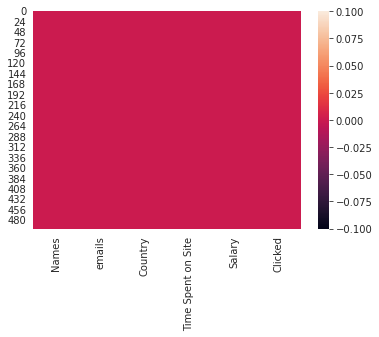

In [8]:
sns.heatmap(facebook.isnull())

In [9]:
numerical_features, categorical_features = divideFeatures(facebook)

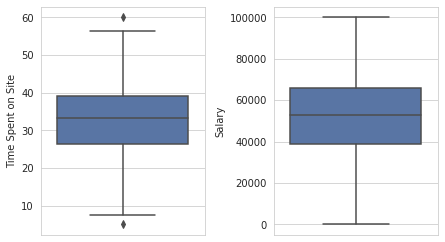

In [10]:
# boxplots of numerical features for outlier detection

fig = plt.figure(figsize=(16,30))
for i in range(len(numerical_features.columns)):
    fig.add_subplot(9, 5, i+1)
    sns.boxplot(y=numerical_features.iloc[:,i])
plt.tight_layout()
plt.show()

plot the % of the target variable

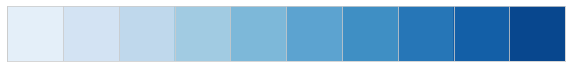

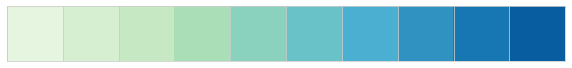

In [11]:
sns.color_palette("Blues", as_cmap=True)
GnBu_palette = sns.color_palette("GnBu",10)
Blues_palette = sns.color_palette("Blues",10)
sns.palplot(Blues_palette)
sns.palplot(GnBu_palette)

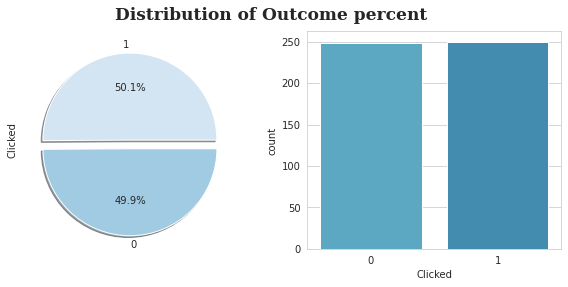

In [12]:
fig, axes = plt.subplots(1,2,figsize=(10,4))

facebook['Clicked'].value_counts().plot.pie(
    explode=[0,0.1],autopct='%1.1f%%',ax=axes[0],shadow=True, colors=[Blues_palette[1],Blues_palette[3]]
)

sns.countplot('Clicked',data=facebook,ax=axes[1], palette=[GnBu_palette[6],GnBu_palette[7]])
axes[1].patch.set_alpha(0)

fig.text(0.28,0.92,"Distribution of Outcome percent", fontweight="bold", fontfamily='serif', fontsize=17)

plt.show()

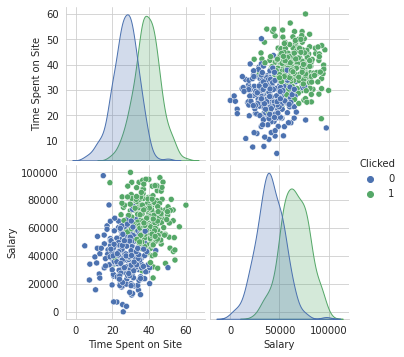

In [13]:
sns.pairplot(facebook, hue = 'Clicked', vars = ['Time Spent on Site', 'Salary'] )

<AxesSubplot:xlabel='Clicked', ylabel='Salary'>

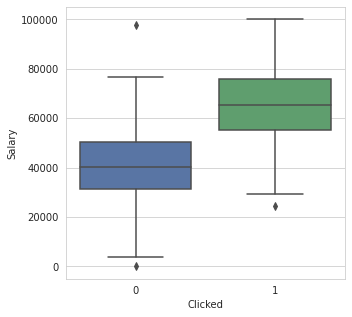

In [14]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='Clicked', y='Salary',data=facebook)

<AxesSubplot:xlabel='Clicked', ylabel='Time Spent on Site'>

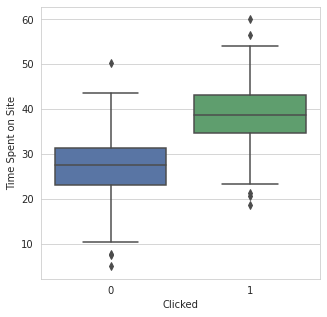

In [15]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='Clicked', y='Time Spent on Site',data=facebook)

In [16]:
facebook[facebook.columns[:8]].corr().style.background_gradient(cmap='Blues')

,Time Spent on Site,Salary,Clicked
Time Spent on Site,1.000000,0.388330,0.650781
Salary,0.388330,1.000000,0.654654
Clicked,0.650781,0.654654,1.000000


# Step 3: Data Cleaning

In [17]:
# drop the Serial No.
facebook.drop(['Names','emails','Country'], axis=1, inplace=True)


datasetShape(facebook)

The dataframe has 499 rows and 3 columns.


# Step 4: Data Preparation

In [18]:
# No data engineering is required!!!


# Step 5: Data Modeling

In [19]:
# shuffle samples
df_shuffle = facebook.sample(frac=1, random_state=seed).reset_index(drop=True)

In [20]:
df_y = df_shuffle.pop('Clicked')
df_X = df_shuffle

# split into train dev and test
X_train, X_test, y_train, y_test = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed)
print(f"Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")

Train set has 349 records out of 499 which is 70%
Test set has 150 records out of 499 which is 30%


Feature Scaling

In [21]:
scaler = skp.StandardScaler()

# apply scaling to all numerical variables except dummy variables as they are already between 0 and 1
X_train[numerical_features.columns] = scaler.fit_transform(X_train[numerical_features.columns])

# scale test data with transform()
X_test[numerical_features.columns] = scaler.transform(X_test[numerical_features.columns])


# view sample data
X_train.describe()

,Time Spent on Site,Salary
count,3.490000e+02,3.490000e+02
mean,-1.781447e-17,-4.580863e-16
std,1.001436e+00,1.001436e+00
min,-2.948498e+00,-2.562069e+00
25%,-7.266208e-01,-7.439130e-01
50%,2.231168e-02,-2.938480e-02
75%,6.885525e-01,7.320860e-01
max,3.182678e+00,2.321312e+00


In [22]:
def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuacy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('confusion')
    print(confusion)
    print('accuacy : {}'.format(np.around(accuacy,4)))
    print('precision: {}'.format(np.around(precision,4)))
    print('recall : {}'.format(np.around(recall,4)))
    print('F1 : {}'.format(np.around(f1,4)))  
    print('ROC_AUC : {}'.format(np.around(roc_auc,4)))

Logistic Regression Model

In [40]:
lg_reg = LogisticRegression()

lg_reg.fit(X_train, y_train)
pred = lg_reg.predict(X_test)
pred_proba = lg_reg.predict_proba(X_test)[:,1]
get_clf_eval(y_test, pred, pred_proba)

confusion
[[66  6]
 [ 3 75]]
accuacy : 0.94
precision: 0.9259
recall : 0.9615
F1 : 0.9434
ROC_AUC : 0.9749


Classiﬁcation Accuracy = (TP+TN) / (TP + TN + FP + FN) 

Misclassiﬁcation rate (Error Rate) = (FP + FN) / (TP + TN + FP + FN) 

Precision = TP/Total TRUE Predictions = TP/ (TP+FP) (When model predicted TRUE class, how often was it right?) 

Recall = TP/ Actual TRUE = TP/ (TP+FN) (when the class was actually TRUE, how often did the classiﬁer get it right?)

F1-Score = 2/(1/Recall + 1/Precision) (is a harmonic mean of Precision and Recall, and so it gives a combined idea about these two metrics. It is maximum when Precision is equal to Recall.)

Random Forest Model

In [26]:
rf_clf = RandomForestClassifier()
param = {'n_estimators' : [100],
         'max_depth':[8,9,10],
         'min_samples_split':[2,5,7],
         'min_samples_leaf':[6.5,7,7.5]
        }

In [29]:
grid = GridSearchCV(rf_clf,param_grid = param,scoring = 'accuracy',cv=5)
grid.fit(X_train ,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [8, 9, 10],
                         'min_samples_leaf': [6.5, 7, 7.5],
                         'min_samples_split': [2, 5, 7],
                         'n_estimators': [100]},
             scoring='accuracy')

In [30]:
grid.best_params_

{'max_depth': 9,
 'min_samples_leaf': 7,
 'min_samples_split': 2,
 'n_estimators': 100}

In [31]:
grid.best_score_

0.879751552795031

In [32]:
pred = grid.predict(X_test)
pred_proba = grid.predict_proba(X_test)[:,1]
get_clf_eval(y_test, pred, pred_proba)

confusion
[[66  6]
 [ 4 74]]
accuacy : 0.9333
precision: 0.925
recall : 0.9487
F1 : 0.9367
ROC_AUC : 0.9671


LightGBM Classification Model

In [36]:
model = lgb.LGBMClassifier(
    n_estimators=400,
    num_leaves=20,
    min_data_in_leaf=60,
    learning_rate=0.01,
    boosting='gbdt',
    objective='binary',
    metric='auc',
    Is_training_metric=True,
    n_jobs=-1
)

In [37]:
model.fit(X_train,y_train)

LGBMClassifier(Is_training_metric=True, boosting='gbdt', learning_rate=0.01,
               metric='auc', min_data_in_leaf=60, n_estimators=400,
               num_leaves=20, objective='binary')

In [38]:
pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]
get_clf_eval(y_test, pred, pred_proba)

confusion
[[65  7]
 [ 6 72]]
accuacy : 0.9133
precision: 0.9114
recall : 0.9231
F1 : 0.9172
ROC_AUC : 0.963


logistic regression model wins!!

confusion

[[66  6]

[ 3 75]]

accuacy : 0.94

precision: 0.9259

recall : 0.9615

F1 : 0.9434

ROC_AUC : 0.9749

# Step 6: Submission

Re-run the best model (Logistic Regression)to update the 'pred' variable

In [41]:
submission = pd.DataFrame(X_test)

In [42]:
submission['Outcome'] = y_test
submission['Predict_Outcome'] = pred

In [43]:
submission.head()

,Time Spent on Site,Salary,Outcome,Predict_Outcome
474,1.329420,0.314328,1,1
385,-0.371787,-0.015755,0,0
167,-1.012418,-1.784377,0,0
40,-1.098243,0.380292,0,0
350,0.641115,2.188550,1,1


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=375c83c5-9c17-48bb-b813-ed40329e9d6c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>